In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal
from utils import audio, channels, synchronize, channel_estimate,ofdm, encode, decode, preamble

cwd = os.getcwd()

In [2]:
#baisc parameter definition
filename = 'frame6'            #rememeber to change everytime

chirp_duration = 1
record_duration = 20
fs = 48000

DFT_LENGTH = 4096
CP_LENGTH = 512
symbol_per_frame = 128
low_freq = 1000
high_freq = 10000

encode_method = 'qpsk'
double_chirp = False
known_ofdm = True

#define chirp used in the signal
chirp_range = [1000,10000]
chirp = preamble.generate_chirp(chirp_duration, fs, low=chirp_range[0], high=chirp_range[1], silence_duration=0, double=double_chirp)

#define known ofdm symbol
seed_known = 48
known_ofdm = True
repeat_time = 4
if known_ofdm:
    known_ofdm_data = preamble.generate_known_ofdm(fs,DFT_LENGTH,CP_LENGTH,low_freq,high_freq,encode_method,repeat_time,seed_known)
else:
    known_ofdm_data = np.array([])
spb = ofdm.subcarriers_per_block(fs,DFT_LENGTH,low_freq,high_freq)

Start recording for 20 seconds...
Finish recording


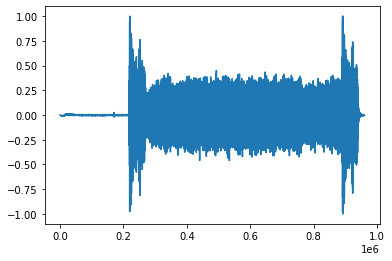

In [3]:
#record and save
received_signal = audio.record(record_duration, fs)
audio.signal_to_wav(received_signal,fs,filename,"audio_files")

In [ ]:
#load recorded signals
received_signal,_ = np.array(audio.wav_to_signal(filename,'audio_files'))

In [4]:
#synchronize: convolve and find
start,convolved = synchronize.chirp_synchronize(received_signal,chirp_range, fs,duration=1)
event_end = np.array(synchronize.impulse_detect(convolved,fs,duration = 1,window_time=0.1,threshold=2))

In [5]:
#plot the convolved result
# plt.plot(convolved)
# for pos in event_end:
#     plt.axvline(x = pos, color = 'r')
# plt.show()

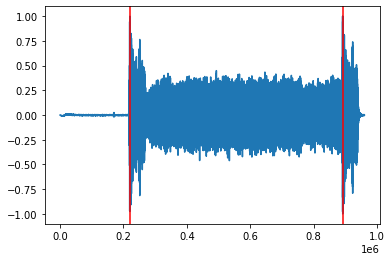

2 chirp events found at [220693 893116] , is that as expected? 


In [32]:
#plot found chirp in received signal
event_start = event_end - fs*chirp_duration
chirp_received = received_signal[event_start[0]:event_start[0]+chirp_duration*fs]   #taking only the first event for the time being

plt.plot(received_signal)
for pos in event_start:
    plt.axvline(x = pos, color = 'r')
plt.show()
event = event_start
print(str(len(event))+" chirp events found at "+ str(event)+" , is that as expected? ")

In [22]:
print(event[1]-event[0]-671616)
event = event-30

807


In [33]:
#estimate with known ofdm
known_ofdm_start = int(event[0] + fs*(chirp_duration)) #need to change accordingly
known_ofdm_end = known_ofdm_start + known_ofdm_data.size
received_known = received_signal[known_ofdm_start:known_ofdm_end]  #received ofdm part

#remove the first cyclic prefix manually then find discarded
received_known = received_known[CP_LENGTH:]
fft_known = ofdm.ofdm_to_fourier(received_known[:], DFT_LENGTH, cp_length=0) 
discarded_known = ofdm.subcarrier_extract(fft_known, DFT_LENGTH, fs, low_freq, high_freq)

#estimate
H_known_ofdm = ofdm.known_ofdm_estimate(discarded_known,repeat_time,known_ofdm_data[CP_LENGTH:],DFT_LENGTH,low_freq,high_freq,fs)


In [10]:
# # estimate with method 3
# chirp_received = received_signal[event[0]:event[0]+chirp_duration*fs]
# reverse_chirp = chirp[::-1]
# estimate = channel_estimate.channelest3(reverse_chirp,chirp_received,fs,hsize=fs)

# #plt.plot(np.abs(np.fft.fft(estimate)[:20000]))
# #plt.title('method 3 estimation '+filename)
# h = estimate
# H = np.fft.fft(h[:])
# plt.plot(H)

In [34]:
#used for ofdm after a chirp only
ofdm_start = int(known_ofdm_end)
end = received_signal.size      #end of the possible range with a signal
correction = (end-ofdm_start)%(DFT_LENGTH+CP_LENGTH)
#ofdm_end = end - correction
ofdm_end = ofdm_start+symbol_per_frame*(DFT_LENGTH+CP_LENGTH)       #hard coded, need to check
received_ofdm =received_signal[ofdm_start:ofdm_end]  #received ofdm information
fft = ofdm.ofdm_to_fourier(received_ofdm, DFT_LENGTH, CP_LENGTH)
discarded = ofdm.subcarrier_extract(fft, DFT_LENGTH, fs, low_freq, high_freq)
deconvolved = ofdm.deconvolve(discarded, H_known_ofdm, DFT_LENGTH, fs, low_freq, high_freq,True)

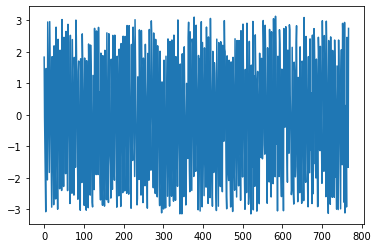

In [25]:
#plot the phase difference between the two channel estimation done with known ofdm symbols
phase_diff,H1,H2 = synchronize.phase_difference(received_signal, event,known_ofdm_data,CP_LENGTH,DFT_LENGTH,fs,low_freq,high_freq,repeat_time)

9.937634766168672e-05 -0.145089574418521


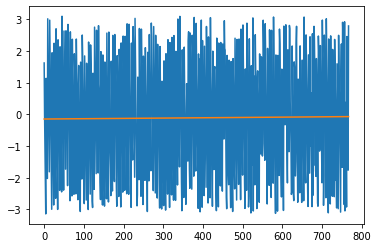

In [13]:
#find regression of the phase diff plot by looking at a selected linear range
slope2=0
intercept2 = 0
start1 = 0
end1 = spb  #select manually
plt.plot(phase_diff[start1:end1])
section1 = phase_diff[start1:end1]
x_1 = np.linspace(0,end1,num=(end1-start1))
slope1, intercept1, r_value, p_value, std_err = scipy.stats.linregress(x_1, section1)
plt.plot(x_1*slope1+intercept1)
print(slope1,intercept1)

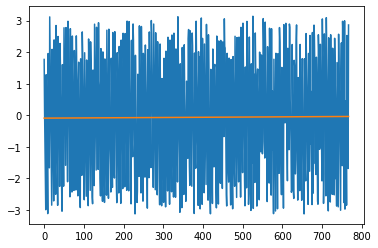

In [14]:
x_2 = np.linspace(0,spb,num=spb)
correction1 = np.exp(-(slope1*x_2+intercept1)*1j)  #compensate with the regression result from last block
phase_diff_1 = np.angle(np.divide(H1,H2)*correction1)
slope2, intercept2, r_value, p_value, std_err = scipy.stats.linregress(x_2, phase_diff_1)
plt.plot(phase_diff_1)
plt.plot(slope2*x_2+intercept2)

0.00016802980078227294 -0.23690234736661345


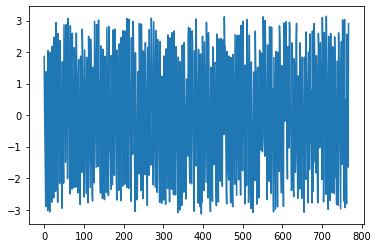

In [15]:
#check that all phase shift is accounted for
correction2 = np.exp(-(slope2*x_2+intercept2)*1j)
phase_diff_3 = np.angle(np.divide(H1,H2)*correction1*correction2)
plt.plot(phase_diff_3)
slope = slope1+slope2
intercept = intercept1+intercept2
print(slope,intercept)

In [16]:
#phase correction, given slope, intercept
#assume slope and intercept increament linearly between all unknown ofdm symbols
slopes = np.linspace(0,slope,num=symbol_per_frame)
intercepts = np.linspace(0,intercept,num=symbol_per_frame)
x_symbol = np.linspace(0,spb,num=spb)
corrected = np.array([])
deconvolved_reshape =  np.reshape(deconvolved,(-1,spb))
#print(deconvolved_reshape.shape)
for i in range(deconvolved_reshape.shape[0]):
    #print(i,slopes[i],intercepts[i])
    phase_correct = np.exp(x_symbol*slopes[i]+intercepts[i])*np.exp(1j)
    corrected = np.append(corrected,deconvolved_reshape[i,:]*phase_correct)
#print(corrected.shape)
deconvolved = corrected

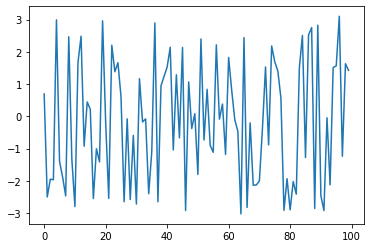

In [35]:
plt.plot(np.angle(deconvolved[:100]))
mdic = {"deconvolved":deconvolved}
#scipy.io.savemat('deconvolved.mat',mdic)

In [36]:
#check accuracy
new = True
if new:
    np.random.seed(24)
    encoded = np.random.randint(2, size=2*128*spb)
    np.savetxt('encoded', encoded, fmt='%i')


98304


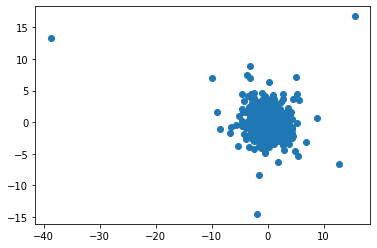

In [37]:
phase_plot_range = 1000
plt.scatter(np.real(deconvolved[:phase_plot_range]),np.imag(deconvolved[:phase_plot_range])) #plot the received phase distribution
#plt.xlim([-5,5])
#plt.ylim([-5,5])
print(deconvolved.size)

In [38]:
if encode_method == 'qpsk':
    decoded = decode.qpsk_decode(deconvolved)
elif encode_method == 'bpsk':
    decoded = decode.bpsk_decode(deconvolved)
print(encoded.size, decoded.size)
print("source:\n", encoded[:30])
print("decoded:\n", decoded[:30])

196608 196608
source:
 [0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0]
decoded:
 [0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0]


In [39]:
equality = encoded == decoded[:encoded.size]
print(equality)
#equality = equality[:768]
print("correct rate:\n", np.sum(equality.astype(int))/equality.size)

[ True False False ... False False False]
correct rate:
 0.5256754557291666


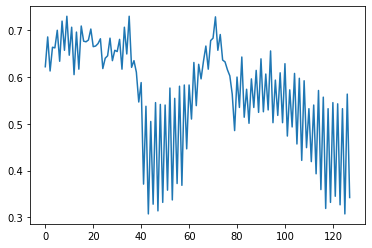

In [40]:
#error of each symbol
e_symbol = [0]*128
for n in np.linspace(0,127,num=128):
    n=int(n)
    a = equality[768*n:768*(n+1)]
    e_symbol[n] = np.round(np.sum(a.astype(int))/a.size,4)
plt.plot(e_symbol)